# MolDrug without receptor

One of the strengths of MolDrug is the ability to optimize on the chemical space based on docking results. However it could also be used to optimize some QSAR function when the information of the receptor is not available. Some previous of this application where show [here](https://moldrug.readthedocs.io/en/latest/notebooks/how_to.html#Create-your-own-cost-function).

## Imports and creating working directory

In [1]:
from pyexpat import model
from moldrug import utils
from rdkit import Chem
from rdkit.Chem import AllChem, Lipinski, Draw
import multiprocessing as mp
import shutil, os, gzip, requests, tempfile

tmp_path = tempfile.TemporaryDirectory()
wd = tmp_path.name
# or
# os.makedirs('tutorial_mwr', exist_ok=True)
# wd = os.path.abspath('tutorial_mwr')


## Getting the CReM data base

In [2]:
url = "http://www.qsar4u.com/files/cremdb/replacements02_sc2.db.gz"
r = requests.get(url, allow_redirects=True)
crem_dbgz_path = os.path.join(wd,'crem.db.gz')
crem_db_path = os.path.join(wd,'crem.db')
open(crem_dbgz_path, 'wb').write(r.content)
with gzip.open(crem_dbgz_path, 'rb') as f_in:
    with open(crem_db_path, 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)

## Define the function
Let's assume that our QSAR model give us that the best molecules are those ones that have more hydrogen bonds acceptor and donors. Because MolDrug minimize we must use the negative of this number.

In [3]:
def QSAR_model_cost(Individual:utils.Individual) -> utils.Individual:
    """Simple cost function

    Parameters
    ----------
    Individual : utils.Individual
        An initialize Individual

    Returns
    -------
    utils.Individual
        The individual with cost sum of HBA and HBD with negative sign
    """
    NumHAcceptors  = Lipinski.NumHAcceptors(Individual.mol)
    NumHDonors = Lipinski.NumHDonors(Individual.mol)
    model = NumHAcceptors + NumHDonors
    Individual.cost = -model
    return Individual

## Set MolDrug run

In [4]:
ga = utils.GA(
    Chem.MolFromSmiles('CCCC'),
    crem_db_path = os.path.join(tmp_path.name, 'crem.db'),
    maxiter = 10,
    popsize = 50,
    costfunc=QSAR_model_cost,
    mutate_crem_kwargs={
        'ncores': mp.cpu_count()
    },
    costfunc_kwargs={}
    )
ga(12)




Creating the first population with 50 members:


100%|██████████| 50/50 [00:00<00:00, 1272.61it/s]

Initial Population: Best individual: Individual(idx = 35, smiles = CC(N)C(=N)NO, cost = -7)


Evaluating generation 1 / 10:


100%|██████████| 50/50 [00:00<00:00, 997.56it/s]

Generation 1: Best Individual: Individual(idx = 35, smiles = CC(N)C(=N)NO, cost = -7).



Evaluating generation 2 / 10:


100%|██████████| 48/48 [00:00<00:00, 417.55it/s]

Generation 2: Best Individual: Individual(idx = 35, smiles = CC(N)C(=N)NO, cost = -7).



Evaluating generation 3 / 10:


100%|██████████| 49/49 [00:00<00:00, 265.61it/s]

Generation 3: Best Individual: Individual(idx = 148, smiles = CC1(C)N=C(N)N=C(N)N1O, cost = -9).



Evaluating generation 4 / 10:


100%|██████████| 46/46 [00:00<00:00, 212.73it/s]

Generation 4: Best Individual: Individual(idx = 202, smiles = O=C(O)C1(O)CC(O)C(O)C(O)C1, cost = -10).



Evaluating generation 5 / 10:


100%|██████████| 49/49 [00:00<00:00, 173.32it/s]

Generation 5: Best Individual: Individual(idx = 202, smiles = O=C(O)C1(O)CC(O)C(O)C(O)C1, cost = -10).



Note: The mutation on Individual(idx = 153, smiles = CC1(O)C(=NO)CC2CC1C2(C)C, cost = -5) did not work, it will be returned the same individual
Note: The mutation on Individual(idx = 153, smiles = CC1(O)C(=NO)CC2CC1C2(C)C, cost = -5) did not work, it will be returned the same individual
Note: The mutation on Individual(idx = 153, smiles = CC1(O)C(=NO)CC2CC1C2(C)C, cost = -5) did not work, it will be returned the same individual
Evaluating generation 6 / 10:


100%|██████████| 47/47 [00:00<00:00, 122.85it/s]

Generation 6: Best Individual: Individual(idx = 202, smiles = O=C(O)C1(O)CC(O)C(O)C(O)C1, cost = -10).



Evaluating generation 7 / 10:


100%|██████████| 50/50 [00:00<00:00, 129.32it/s]

Generation 7: Best Individual: Individual(idx = 352, smiles = OCC(O)C(O)C(O)C(O)C1SCCCS1, cost = -12).



Evaluating generation 8 / 10:


100%|██████████| 50/50 [00:00<00:00, 118.14it/s]

Generation 8: Best Individual: Individual(idx = 426, smiles = NNC(=O)C(O)C(O)C(O)C(O)CO, cost = -14).



Evaluating generation 9 / 10:


100%|██████████| 49/49 [00:00<00:00, 88.03it/s]

Generation 9: Best Individual: Individual(idx = 426, smiles = NNC(=O)C(O)C(O)C(O)C(O)CO, cost = -14).



Evaluating generation 10 / 10:


100%|██████████| 49/49 [00:00<00:00, 86.79it/s]

Generation 10: Best Individual: Individual(idx = 499, smiles = NNC(=O)C(O)C(O)C(O)C(O)C(O)C=O, cost = -15).


=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

The simulation finished successfully after 10 generations with a population of 50 individuals. A total number of 534 Individuals were seen during the simulation.
Initial Individual: Individual(idx = 0, smiles = CCCC, cost = 0)
Final Individual: Individual(idx = 499, smiles = NNC(=O)C(O)C(O)C(O)C(O)C(O)C=O, cost = -15)
The cost function droped in 15 units.

=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+=+

Total time (10 generations): 335.81 (s).
Finished at Mon Aug 29 01:17:50 2022.



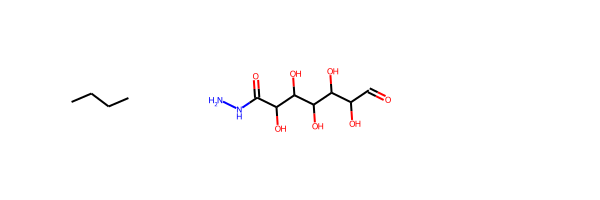

In [5]:
Draw.MolsToGridImage([ga.InitIndividual.mol, ga.pop[0].mol])

As you can see, this simulation is really good: On every single carbon atom it is bound, at least, one HBD and/or HBA! (Your results could differ)

[Text(0.5, 1.0, 'best_cost')]

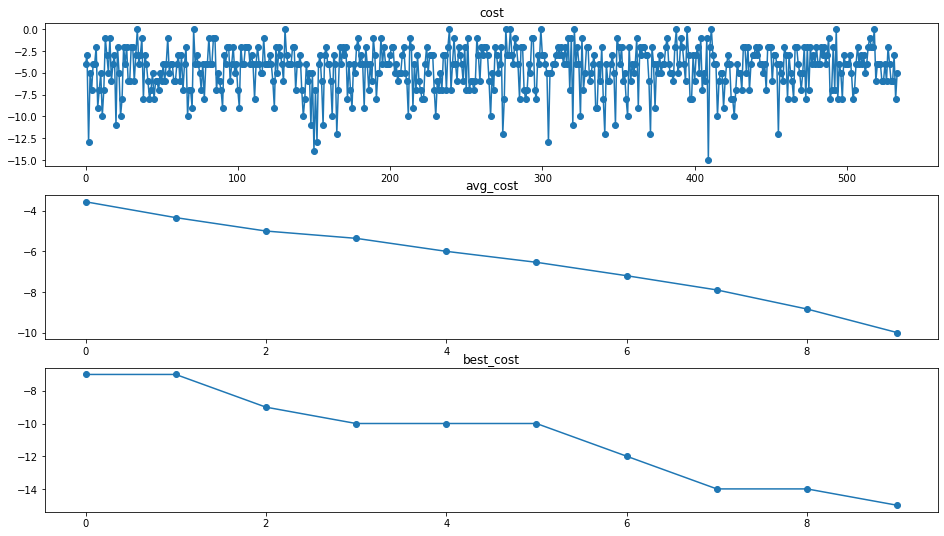

In [8]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=3,  figsize = (16,9))
ax[0].plot([individual.cost for individual in ga.SawIndividuals], '-o')
ax[0].set(title = 'cost')
ax[1].plot([cost for cost in ga.avg_cost], '-o')
ax[1].set(title = 'avg_cost')
ax[2].plot([cost for cost in ga.best_cost], '-o')
ax[2].set(title = 'best_cost')